In [1]:
from nuscenes.nuscenes import NuScenes
# data_dir = "/home/umair/workspace/datasets/nuscenes_radar/"
data_dir = "/shared/data/nuScenes/"
sensors = ["RADAR_FRONT", "RADAR_FRONT_LEFT", "RADAR_FRONT_RIGHT", "RADAR_BACK_LEFT", "RADAR_BACK_RIGHT"]
versions = {'trainval': 'v1.0-trainval', 'test': 'v1.0-test'}
nuscenes_exp = {
            vname : NuScenes(dataroot=data_dir, version=version, verbose=False)\
                for vname,version in versions.items()
}

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from nuscenes.nuscenes import NuScenes
from scipy.spatial import KDTree
from IPython.display import display

nusc_trainval = nuscenes_exp['trainval']
nusc_test = nuscenes_exp['test']

# Combine the scenes
combined_scenes = [{'scene': scene, 'split': 'trainval'} for scene in nusc_trainval.scene] + [{'scene': scene, 'split': 'test'} for scene in nusc_test.scene]

In [3]:
combined_scenes[0]

{'scene': {'token': '73030fb67d3c46cfb5e590168088ae39',
  'log_token': '6b6513e6c8384cec88775cae30b78c0e',
  'nbr_samples': 40,
  'first_sample_token': 'e93e98b63d3b40209056d129dc53ceee',
  'last_sample_token': '40e413c922184255a94f08d3c10037e0',
  'name': 'scene-0001',
  'description': 'Construction, maneuver between several trucks'},
 'split': 'trainval'}

In [ ]:
import pandas as pd
from nuscenes.nuscenes import NuScenes

# Dictionary to hold scene names and their object classes
scene_objects = {}

# Iterate through the combined_scenes list
for scene_obj in combined_scenes:
    scene = scene_obj['scene']
    scene_split = scene_obj['split']
    scene_name = scene['name']
    nusc = nuscenes_exp[scene_split]
    # Initialize an empty set to store unique object classes in this scene
    object_classes = set()

    # Get all sample tokens for this scene
    sample_token = scene['first_sample_token']
    while sample_token:
        sample = nusc.get('sample', sample_token)
        
        # Get 2D annotations for each sample_data
        for sensor in ['LIDAR_TOP']: #['CAM_FRONT', 'CAM_BACK', 'CAM_BACK_LEFT', 'CAM_BACK_RIGHT', 'CAM_FRONT_LEFT', 'CAM_FRONT_RIGHT']:
            sample_data_token = sample['data'][sensor]
            sd_record = nusc.get('sample_data', sample_data_token)
            
            
            
            for annotation_token in sample['anns']:
                # Assuming each annotation has a 'detection_name' and 'detection_label'
                # class_name = annotation.name
                # att_token = annotation.
                annotation_metadata =  nusc.get('sample_annotation', annotation_token)
                atokens = annotation_metadata['attribute_tokens']
                for token in atokens:
                    attribute = nusc.get('attribute', token)
                    name = attribute['name']
                    object_classes.add(name)
        
        # Move to the next sample
        sample_token = sample['next']
    
    # Store the list of unique object classes for this scene
    scene_objects[scene_name] = list(object_classes)

# Now scene_objects contains the desired information
print(scene_objects)

In [6]:
# scenes_subset = [e for e in combined_scenes if e['scene']['name'] in ['scene-0062', 'scene-0092', 'scene-0165', 'scene-0199']]
# scenes_subset

In [7]:
# Helper function to convert timestamp to datetime
def timestamp_to_datetime(timestamp):
    return datetime.fromtimestamp(timestamp / 1e6)

# Extract the first frame datetime for each scene and calculate the days passed since the first scene
scene_info = []

# Find the earliest datetime in the combined dataset
first_timestamps = [
    nusc_trainval.get('sample_data', nusc_trainval.get('sample', scene['first_sample_token'])['data']['RADAR_FRONT'])['timestamp']
    for scene in nusc_trainval.scene
] + [
    nusc_test.get('sample_data', nusc_test.get('sample', scene['first_sample_token'])['data']['RADAR_FRONT'])['timestamp']
    for scene in nusc_test.scene
]
earliest_timestamp = min(first_timestamps)
earliest_datetime = timestamp_to_datetime(earliest_timestamp)
print(earliest_datetime)
# combined_scenes = scenes_subset
for item in combined_scenes:
    scene = item['scene']
    split = item['split']
    first_sample_token = scene['first_sample_token']
    nusc = nuscenes_exp[split]
    
    first_sample = nusc.get('sample', first_sample_token)
    first_sample_data = nusc.get('sample_data', first_sample['data']['RADAR_FRONT'])
    
    first_frame_ts = first_sample_data['timestamp']
    first_frame_datetime = timestamp_to_datetime(first_frame_ts)
    days_passed = (first_frame_datetime - earliest_datetime).days
    hours_passed = (first_frame_datetime - earliest_datetime).total_seconds() / 3600
    month = first_frame_datetime.strftime("%B")
    
    scene_info.append({
        'scene_name': scene['name'],
        'first_frame_datetime': first_frame_datetime,
        'days_since_first_recording': days_passed,
        'hours_since_first_recording': hours_passed,
        'month': month,
        'split': split
    })

# Create DataFrame
scene_df = pd.DataFrame(scene_info)
scene_df.sort_values(by='first_frame_datetime', inplace=True)

display(scene_df.head(10))

2018-05-21 15:07:23.042374


,scene_name,first_frame_datetime,days_since_first_recording,hours_since_first_recording,month,split
121,scene-0161,2018-05-21 15:07:23.042374,0,0.000000,May,trainval
122,scene-0162,2018-05-21 15:07:43.034762,0,0.005553,May,trainval
123,scene-0163,2018-05-21 15:08:03.050124,0,0.011113,May,trainval
124,scene-0164,2018-05-21 15:08:38.041182,0,0.020833,May,trainval
125,scene-0165,2018-05-21 15:09:15.077959,0,0.031121,May,trainval
126,scene-0166,2018-05-21 15:09:35.054275,0,0.036670,May,trainval
127,scene-0167,2018-05-21 15:10:13.046092,0,0.047223,May,trainval
128,scene-0168,2018-05-21 15:10:52.038646,0,0.058055,May,trainval
129,scene-0170,2018-05-21 15:13:37.015821,0,0.103882,May,trainval
130,scene-0171,2018-05-21 15:13:57.012069,0,0.109436,May,trainval


In [4]:
import numpy as np

def normalize_vector(v):
    """Normalize a vector to unit length."""
    return v / np.linalg.norm(v)

def cosine_similarity(v1, v2):
    """Compute the cosine similarity between two vectors."""
    return np.dot(v1, v2)

def calculate_direction_vector(positions):
    """Calculate the direction vector of a trajectory given a list of positions."""
    displacements = positions[1:] - positions[:-1]
    avg_displacement = np.mean(displacements, axis=0)
    return normalize_vector(avg_displacement)

def average_euclidean_distance(positions1, positions2):
    """Calculate the average Euclidean distance between two lists of positions."""
    distances = np.linalg.norm(positions1 - positions2, axis=1)
    return np.mean(distances)

def find_similar_trajectories(query_positions, recordings, direction_threshold=0.3, distance_threshold=25.0):
    """Find trajectories similar to the query_positions in the given recordings."""
    query_direction_vector = calculate_direction_vector(query_positions)
    
    similar_trajectories = []
    
    for recording in recordings:
        recording_positions = np.array(recording)
        recording_direction_vector = calculate_direction_vector(recording_positions)
        
        # Calculate direction similarity
        direction_similarity = cosine_similarity(query_direction_vector, recording_direction_vector)
        
        if direction_similarity >= direction_threshold:
            # Calculate average Euclidean distance
            euclidean_distance = average_euclidean_distance(query_positions, recording_positions)
            
            if euclidean_distance <= distance_threshold:
                similar_trajectories.append((recording, direction_similarity, euclidean_distance))
    
    # Sort by direction similarity and Euclidean distance
    similar_trajectories.sort(key=lambda x: (x[1], -x[2]), reverse=True)
    
    return similar_trajectories

In [9]:
import numpy as np
import pandas as pd
from scipy.spatial import KDTree
from datetime import datetime, timedelta

def find_closest_scenes(scene_df, nuscenes_exp, sensor_channel='RADAR_FRONT', num_closest=50, distance_threshold=25.0, min_match_percentage=0.1):
    visited_scenes = set()
    scene_info = []
    
    for index, row in scene_df.iterrows():
        target_scene_name = row['scene_name']
        print(target_scene_name)
        if target_scene_name in visited_scenes:
            scene_info.append({
                'scene_name': "",
                'closest_scenes': [],
                'closest_scenes_data': {},
                'month': "",
            })
            continue
        split = row['split']
        day = row['days_since_first_recording']
        hours = row['hours_since_first_recording']
        nusc = nuscenes_exp[split]
        
        # Get the scene token for the target scene
        target_scene = next(scene for scene in nusc.scene if scene['name'] == target_scene_name)
        target_scene_token = target_scene['token']
        
        # Get all sample tokens in the target scene
        target_sample_tokens = [samp['token'] for samp in nusc.sample if samp['scene_token'] == target_scene_token]
        
        # Extract radar positions and timestamps for the target scene
        target_positions = []
        target_timestamps = []
        for samp_token in target_sample_tokens:
            sample_data = nusc.get('sample_data', nusc.get('sample', samp_token)['data'][sensor_channel])
            pose_record = nusc.get('ego_pose', sample_data['ego_pose_token'])
            target_positions.append(np.array(pose_record['translation']))
            target_timestamps.append(pose_record['timestamp'])
        target_positions = np.array(target_positions)
        
        # Build a KD-Tree for the target positions
        target_kdtree = KDTree(target_positions)
        target_direction_vector = calculate_direction_vector(target_positions)
        
        # Extract radar positions and timestamps for all other scenes
        all_scene_data = [e for e in combined_scenes if e['scene']['token'] != target_scene_token]
        scene_distances = []
        scene_positions_dict = {}
        scene_timestamps_dict = {}
        matching_indices = {}
        
        for other_scene_dict in all_scene_data:
            scene_token = other_scene_dict['scene']['token']
            scene_name = other_scene_dict['scene']['name']
            scene_split = other_scene_dict['split']
            scene_nusc = nuscenes_exp[scene_split]
            sample_tokens = [samp['token'] for samp in scene_nusc.sample if samp['scene_token'] == scene_token]
            scene_positions = []
            scene_timestamps = []
            for samp_token in sample_tokens:
                sample_data = scene_nusc.get('sample_data', scene_nusc.get('sample', samp_token)['data'][sensor_channel])
                pose_record = scene_nusc.get('ego_pose', sample_data['ego_pose_token'])
                scene_positions.append(np.array(pose_record['translation']))
                scene_timestamps.append(pose_record['timestamp'])
            scene_positions = np.array(scene_positions)
            scene_positions_dict[scene_token] = scene_positions
            scene_timestamps_dict[scene_token] = scene_timestamps
            
            # Query the KD-Tree for each position in the current scene
            distances, indices = target_kdtree.query(scene_positions)
            mean_distance = np.mean(distances)
            
            scene_direction_vector = calculate_direction_vector(scene_positions)
            # Calculate direction similarity
            direction_similarity = cosine_similarity(target_direction_vector, scene_direction_vector)

            scene_distances.append((scene_token, mean_distance, direction_similarity))
            
            # Store matching indices where the distance is below the threshold
            matching_indices[scene_token] = [(i, indices[i]) for i in range(len(distances)) if distances[i] < distance_threshold]
            
            # Calculate the percentage of matches
            match_percentage = len(matching_indices[scene_token]) / len(distances)
            if match_percentage < min_match_percentage:
                # Remove scene from matches if it doesn't meet the match percentage threshold
                matching_indices[scene_token] = []
        
        # Sort scenes by the smallest mean distance
        scene_distances = list(sorted(scene_distances, key=lambda x: (-x[2], x[1])))
        
        # Get the closest scenes that meet the criteria
        closest_scenes = [(scene, dist, ort) for scene, dist, ort in scene_distances if matching_indices[scene]]
        closest_scenes = closest_scenes[:num_closest]
        closest_scene_tokens = list(map(lambda x: x[0], closest_scenes))
        
        closest_scenes_data = {}
        for scene_token, mean_dist, ort_sim in closest_scenes:
            scene_name = [e['scene']['name'] for e in combined_scenes if e['scene']['token'] == scene_token][-1]
            close_scene_row = scene_df[scene_df.scene_name == scene_name].iloc[0]
            scene_split = close_scene_row['split']
            first_match_idx, last_match_idx = matching_indices[scene_token][0][0], matching_indices[scene_token][-1][0]
            first_match_timestamp = scene_timestamps_dict[scene_token][first_match_idx]
            last_match_timestamp = scene_timestamps_dict[scene_token][last_match_idx]
            days_passed = close_scene_row['days_since_first_recording'] - day
            hours_passed = close_scene_row['hours_since_first_recording'] - hours

            closest_scenes_data[scene_name] = {
                'scene_token': scene_token,
                'matching_indices': matching_indices[scene_token],
                'split': scene_split,
                'days_passed': days_passed,
                'hours_passed': hours_passed,
                'mean_distance': mean_dist,
                'trajectory_similarity': ort_sim,
                'first_match_timestamp': first_match_timestamp,
                'last_match_timestamp': last_match_timestamp
            }
            visited_scenes.add(scene_name)
        
        # Calculate the month of the recording and days passed since the first recording
        first_sample_data = nusc.get('sample_data', nusc.get('sample', target_sample_tokens[0])['data'][sensor_channel])
        first_frame_datetime = timestamp_to_datetime(first_sample_data['timestamp'])
        month = first_frame_datetime.strftime("%B")
        
        scene_info.append({
            'scene_name': target_scene_name,
            'closest_scenes': [e['scene']['name'] for e in combined_scenes if e['scene']['token'] in closest_scene_tokens],
            'closest_scenes_data': closest_scenes_data,
            'month': month,
        })

    # Update DataFrame
    scene_df['closest_scenes'] = [info['closest_scenes'] for info in scene_info]
    scene_df['closest_scenes_data'] = [info['closest_scenes_data'] for info in scene_info]
    scene_df['month'] = [info['month'] for info in scene_info]
    
    return scene_df

# Example usage
updated_scene_df = find_closest_scenes(scene_df, nuscenes_exp)

scene-0161
scene-0162
scene-0163
scene-0164
scene-0165
scene-0166
scene-0167
scene-0168
scene-0170
scene-0171
scene-0172
scene-0173
scene-0174
scene-0175
scene-0176
scene-0268
scene-0269
scene-0270
scene-0271
scene-0272
scene-0273
scene-0274
scene-0275
scene-0276
scene-0277
scene-0278
scene-0221
scene-0001
scene-0002
scene-0004
scene-0005
scene-0006
scene-0007
scene-0008
scene-0009
scene-0010
scene-0011
scene-0012
scene-0013
scene-0014
scene-0015
scene-0016
scene-0017
scene-0018
scene-0019
scene-0020
scene-0021
scene-0022
scene-0023
scene-0024
scene-0025
scene-0026
scene-0027
scene-0028
scene-0029
scene-0030
scene-0031
scene-0032
scene-0033
scene-0034
scene-0035
scene-0036
scene-0038
scene-0039
scene-0041
scene-0042
scene-0043
scene-0044
scene-0045
scene-0046
scene-0047
scene-0048
scene-0049
scene-0050
scene-0051
scene-0052
scene-0053
scene-0054
scene-0055
scene-0056
scene-0057
scene-0058
scene-0059
scene-0060
scene-0061
scene-0279
scene-0280
scene-0281
scene-0282
scene-0307
scene-0308

In [10]:
matched_scenes_df = updated_scene_df[updated_scene_df.closest_scenes.apply(lambda x: len(x) > 0)]
matched_scenes_df

,scene_name,first_frame_datetime,days_since_first_recording,hours_since_first_recording,month,split,closest_scenes,closest_scenes_data
121,scene-0161,2018-05-21 15:07:23.042374,0,0.000000,May,trainval,"[scene-0075, scene-0162, scene-0214, scene-021...",{'scene-0264': {'scene_token': '9833ac6de5ae41...
123,scene-0163,2018-05-21 15:08:03.050124,0,0.011113,May,trainval,"[scene-0075, scene-0162, scene-0214, scene-021...",{'scene-0075': {'scene_token': '01c3f5e3995640...
124,scene-0164,2018-05-21 15:08:38.041182,0,0.020833,May,trainval,"[scene-0076, scene-0328, scene-0456, scene-051...",{'scene-0513': {'scene_token': 'e333874a12d64a...
125,scene-0165,2018-05-21 15:09:15.077959,0,0.031121,May,trainval,"[scene-0062, scene-0092, scene-0166, scene-019...",{'scene-0166': {'scene_token': '15e1fa06e30e43...
127,scene-0167,2018-05-21 15:10:13.046092,0,0.047223,May,trainval,"[scene-0064, scene-0200, scene-0202, scene-032...",{'scene-0079': {'scene_token': '1e4818b3b2354b...
...,...,...,...,...,...,...,...,...
820,scene-1080,2018-11-21 11:40:27.982225,183,4412.551372,November,trainval,"[scene-0505, scene-0519, scene-0884, scene-088...",{'scene-0519': {'scene_token': 'b07358651c604e...
826,scene-1086,2018-11-21 11:42:48.076828,183,4412.590287,November,trainval,"[scene-0736, scene-1085, scene-1089, scene-1092]",{'scene-0736': {'scene_token': '2f9da038274a44...
828,scene-1088,2018-11-21 11:43:48.060921,183,4412.606950,November,trainval,"[scene-0070, scene-0207, scene-0208, scene-044...",{'scene-0447': {'scene_token': 'e757a98aa8794d...
835,scene-1095,2018-11-21 11:47:47.942358,183,4412.673583,November,trainval,"[scene-0094, scene-0287, scene-0462, scene-109...",{'scene-1094': {'scene_token': 'de7d80a1f5fb4c...


#### Post-Processing and Verification of Matches

In [11]:
len(matched_scenes_df['scene_name'].tolist()) == len(matched_scenes_df['scene_name'].unique())

True

In [12]:
scene_distances = matched_scenes_df['closest_scenes_data'].apply(lambda x: min([e['mean_distance'] for e in x.values()]))
scene_distances

121     1.342027
123     3.260659
124     4.454119
125     2.728714
127     0.960449
         ...    
820    20.670868
826    16.766894
828    20.900647
835     0.033634
847    11.870962
Name: closest_scenes_data, Length: 155, dtype: float64

In [13]:
scene_distances.median()

5.010636740823443

In [18]:
## Filter based on the median scene distance
def filter_matched_scenes(df, distance_thresh=25):
    new_df = pd.DataFrame([], columns=df.columns)

    for i, row in df.iterrows():
        closest_scenes_data = row['closest_scenes_data']
        new_closest_scenes = []
        new_closest_scenes_data = {}
        for scene_name, data_dict in closest_scenes_data.items():
            if (data_dict['mean_distance'] <= distance_thresh) & (data_dict['trajectory_similarity'] > 0.3) & (data_dict['days_passed'] >= 0) & (data_dict['hours_passed'] >= 0.25):
                new_closest_scenes.append(scene_name)
                new_closest_scenes_data[scene_name] = data_dict
        row['closest_scenes'] = new_closest_scenes
        row['closest_scenes_data'] = new_closest_scenes_data
        new_df.loc[i] = row
    return new_df[new_df.closest_scenes.apply(lambda x: len(x) > 0)]

In [20]:
filtered_matched_scenes_df = filter_matched_scenes(matched_scenes_df)
filtered_matched_scenes_df

,scene_name,first_frame_datetime,days_since_first_recording,hours_since_first_recording,month,split,closest_scenes,closest_scenes_data
121,scene-0161,2018-05-21 15:07:23.042374,0,0.000000,May,trainval,"[scene-0218, scene-0665]",{'scene-0218': {'scene_token': 'febc1800b9ed43...
123,scene-0163,2018-05-21 15:08:03.050124,0,0.011113,May,trainval,"[scene-0075, scene-0511, scene-0332, scene-045...",{'scene-0075': {'scene_token': '01c3f5e3995640...
124,scene-0164,2018-05-21 15:08:38.041182,0,0.020833,May,trainval,"[scene-0513, scene-0091]",{'scene-0513': {'scene_token': 'e333874a12d64a...
125,scene-0165,2018-05-21 15:09:15.077959,0,0.031121,May,trainval,"[scene-0092, scene-0333, scene-0265, scene-0062]",{'scene-0092': {'scene_token': '7365495b744646...
127,scene-0167,2018-05-21 15:10:13.046092,0,0.047223,May,trainval,"[scene-0079, scene-0653, scene-0442, scene-032...",{'scene-0079': {'scene_token': '1e4818b3b2354b...
...,...,...,...,...,...,...,...,...
964,scene-0839,2018-10-02 03:28:33.670479,133,3204.352952,October,test,[scene-1018],{'scene-1018': {'scene_token': 'faa975eaad804c...
967,scene-0842,2018-10-02 03:29:45.665130,133,3204.372951,October,test,"[scene-1022, scene-1023]",{'scene-1022': {'scene_token': '797700339b014f...
710,scene-0925,2018-10-08 07:48:29.871928,139,3352.685230,October,trainval,"[scene-1040, scene-1041, scene-0861]",{'scene-1040': {'scene_token': '7c315a1db2ac49...
343,scene-0429,2018-10-08 07:57:20.624530,139,3352.832662,October,trainval,"[scene-1008, scene-1009]",{'scene-1008': {'scene_token': 'c610d0ac2e2045...


In [21]:
target_scenes = filtered_matched_scenes_df['scene_name'].tolist()
matched_scenes = filtered_matched_scenes_df['closest_scenes'].tolist()
duplication = [t in m for t,m in zip(target_scenes, matched_scenes)]
any(duplication)

False

In [22]:
# filtered_matched_scenes_df.to_pickle("sps_ortsim_nuscenes_df.pkl")

In [23]:
# sps_df = pd.read_pickle("sps_ortsim_nuscenes_df.pkl")
sps_df = filtered_matched_scenes_df
sps_df

,scene_name,first_frame_datetime,days_since_first_recording,hours_since_first_recording,month,split,closest_scenes,closest_scenes_data
121,scene-0161,2018-05-21 15:07:23.042374,0,0.000000,May,trainval,"[scene-0218, scene-0665]",{'scene-0218': {'scene_token': 'febc1800b9ed43...
123,scene-0163,2018-05-21 15:08:03.050124,0,0.011113,May,trainval,"[scene-0075, scene-0511, scene-0332, scene-045...",{'scene-0075': {'scene_token': '01c3f5e3995640...
124,scene-0164,2018-05-21 15:08:38.041182,0,0.020833,May,trainval,"[scene-0513, scene-0091]",{'scene-0513': {'scene_token': 'e333874a12d64a...
125,scene-0165,2018-05-21 15:09:15.077959,0,0.031121,May,trainval,"[scene-0092, scene-0333, scene-0265, scene-0062]",{'scene-0092': {'scene_token': '7365495b744646...
127,scene-0167,2018-05-21 15:10:13.046092,0,0.047223,May,trainval,"[scene-0079, scene-0653, scene-0442, scene-032...",{'scene-0079': {'scene_token': '1e4818b3b2354b...
...,...,...,...,...,...,...,...,...
964,scene-0839,2018-10-02 03:28:33.670479,133,3204.352952,October,test,[scene-1018],{'scene-1018': {'scene_token': 'faa975eaad804c...
967,scene-0842,2018-10-02 03:29:45.665130,133,3204.372951,October,test,"[scene-1022, scene-1023]",{'scene-1022': {'scene_token': '797700339b014f...
710,scene-0925,2018-10-08 07:48:29.871928,139,3352.685230,October,trainval,"[scene-1040, scene-1041, scene-0861]",{'scene-1040': {'scene_token': '7c315a1db2ac49...
343,scene-0429,2018-10-08 07:57:20.624530,139,3352.832662,October,trainval,"[scene-1008, scene-1009]",{'scene-1008': {'scene_token': 'c610d0ac2e2045...


In [18]:
unique_rows = sps_df.scene_name.unique().tolist()
closest_scenes = []
[closest_scenes.extend(l) for l in sps_df.closest_scenes.tolist()]
unique_closest_scenes = np.unique(closest_scenes)
len(unique_rows), len(closest_scenes), len(unique_closest_scenes), "Average Matches: 2.6"

(158, 374, 362)

In [19]:
duplication = set(unique_rows).intersection(set(closest_scenes))
duplication, len(duplication)

(set(), 0)

In [26]:
days_passed_dist = []
[days_passed_dist.extend(d.values()) for d in sps_df.closest_scenes_data.tolist()]
assert(len(days_passed_dist) == len(closest_scenes))
days_passed_dist = [d['days_passed'] for d in days_passed_dist]
days_passed_dist[:10]

[67, 99, 67, 67, 72, 99, 93, 120, 72, 99]

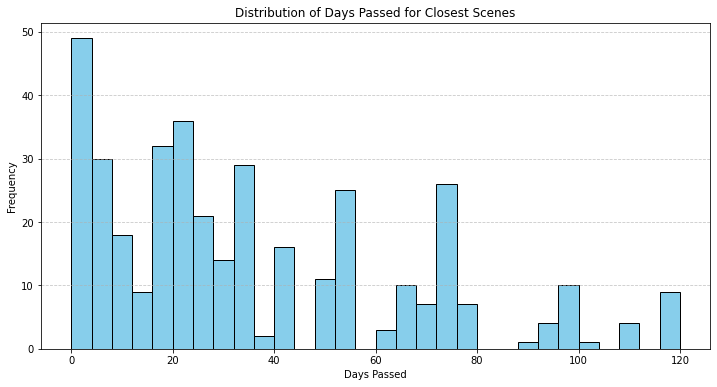

In [27]:
plt.figure(figsize=(12, 6))
plt.hist(days_passed_dist, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Days Passed for Closest Scenes')
plt.xlabel('Days Passed')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [28]:
hours_passed_dist = []
[hours_passed_dist.extend(d.values()) for d in sps_df.closest_scenes_data.tolist()]
assert(len(hours_passed_dist) == len(closest_scenes))
hours_passed_dist = [d['hours_passed'] for d in hours_passed_dist]
hours_passed_dist[:10]

[1609.0217006217,
 2381.1668846192,
 1609.0161471806,
 1609.0283717775,
 1732.8987199806,
 2378.7705880544,
 2236.9342565711,
 2881.1229104872,
 1733.0660785294,
 2378.7720122444]

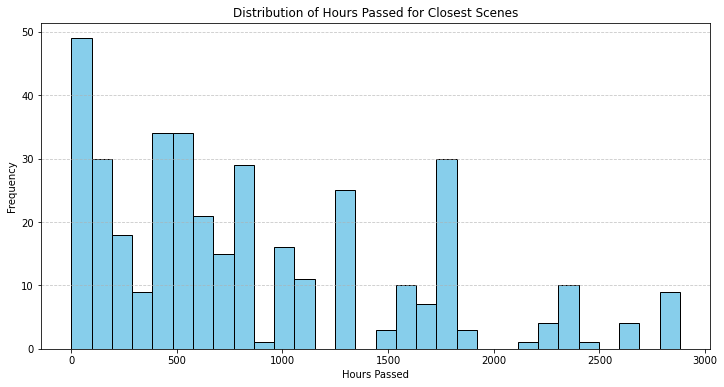

In [29]:
plt.figure(figsize=(12, 6))
plt.hist(hours_passed_dist, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Hours Passed for Closest Scenes')
plt.xlabel('Hours Passed')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [30]:
len([h for h in hours_passed_dist if h <= 0.5]), len(hours_passed_dist)

(0, 374)

In [31]:
matches_dist = [len(l) for l in sps_df.closest_scenes.tolist()]
matches_dist[:10]

[1, 3, 5, 2, 4, 4, 5, 9, 4, 3]

In [32]:
np.average(matches_dist)

2.367088607594937

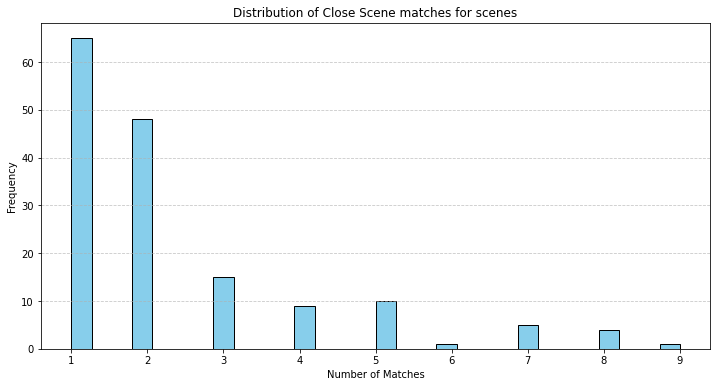

In [33]:
plt.figure(figsize=(12, 6))
plt.hist(matches_dist, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Close Scene matches for scenes')
plt.xlabel('Number of Matches')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [33]:
# Finding scenes with a lot of dynamic objects

dynamic_names = ['vehicle.moving',
'vehicle.stopped',
'vehicle.parked',
'cycle.with_rider',
'cycle.without_rider',
'pedestrian.sitting_lying_down',
'pedestrian.standing',
'pedestrian.moving'
]
dynamic_scene_counts = {name: len([c for c in obj_list if c in dynamic_names]) for name, obj_list in scene_objects.items() if name in sps_df.scene_name.tolist()}
top_list = sorted(dynamic_scene_counts, key=lambda x: dynamic_scene_counts[x], reverse=True)
top_list[:3], dynamic_scene_counts[top_list[0]]

(['scene-0042', 'scene-0232', 'scene-0276'], 8)

In [34]:
top_list[-3:]

['scene-0932', 'scene-0935', 'scene-0943']

In [35]:
high_match = sps_df[sps_df['closest_scenes'].apply(lambda x: len(x) > 8)]
high_match

,scene_name,first_frame_datetime,days_since_first_recording,hours_since_first_recording,month,split,closest_scenes,closest_scenes_data
128,scene-0168,2018-05-21 15:10:52.038646,0,0.058055,May,trainval,"[scene-0655, scene-0204, scene-0444, scene-008...",{'scene-0655': {'scene_token': 'bebf5f5b2a6746...
8,scene-0009,2018-07-18 03:24:57.959983,57,1380.293033,July,trainval,"[scene-0051, scene-0380, scene-0379, scene-015...",{'scene-0051': {'scene_token': '0e37d4a357db42...
176,scene-0227,2018-07-27 16:14:08.154957,67,1609.112531,July,trainval,"[scene-0671, scene-0463, scene-0704, scene-024...",{'scene-0671': {'scene_token': 'd1ece215e0a844...
185,scene-0236,2018-07-27 16:22:16.026232,67,1609.248051,July,trainval,"[scene-0478, scene-0424, scene-0103, scene-086...",{'scene-0478': {'scene_token': '69e393da7cb54e...


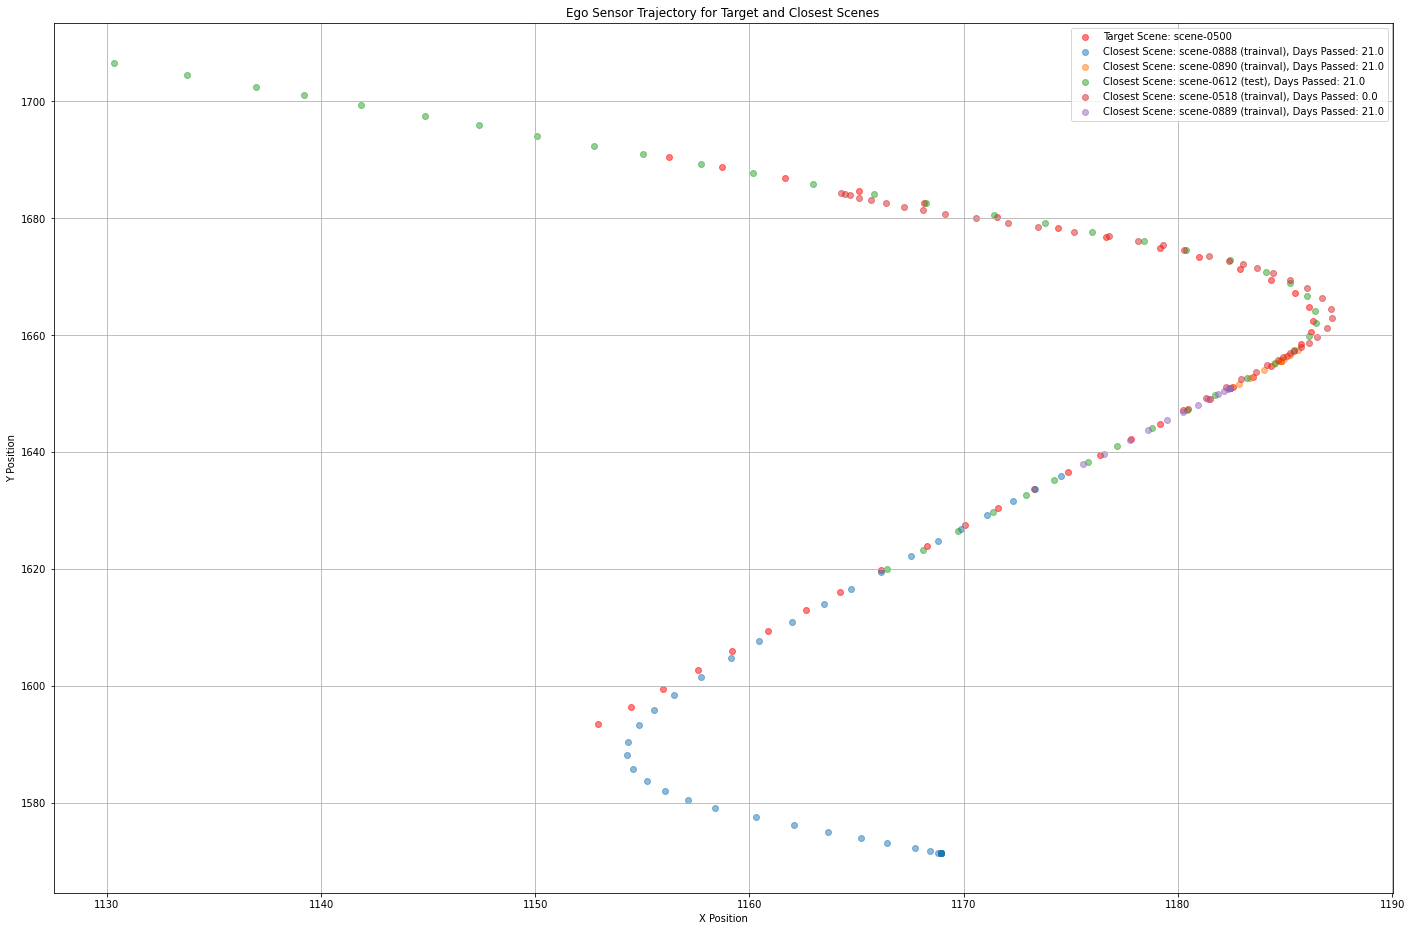

In [15]:
import matplotlib.pyplot as plt
def scene_name_exists(df, scene_name):
    exists = df['closest_scenes'].apply(lambda x: scene_name in x)
    indices = df[exists].index.tolist()
    return exists.any(), indices

def visualize_closest_scenes(nuscenes_exp, updated_scene_df, target_scene_name, sensor_channel='RADAR_FRONT', plot_matched_only=False):
    target_scene_row = updated_scene_df[updated_scene_df['scene_name'] == target_scene_name]
    if len(target_scene_row) == 0:
        exists, indices = scene_name_exists(updated_scene_df, target_scene_name)
        if exists:
            target_scene_row = updated_scene_df.iloc[indices[0]]
        else:
            print(f"Query scene {target_scene_name} not found")
            return
    else:
        target_scene_row = target_scene_row.iloc[0]
        
    target_split = target_scene_row['split']
    nusc_target = nuscenes_exp[target_split]
    
    closest_scenes = target_scene_row['closest_scenes']
    closest_scenes_data = target_scene_row['closest_scenes_data']
    
    # Get the scene token for the target scene
    target_scene = next(scene for scene in nusc_target.scene if scene['name'] == target_scene_name)
    target_scene_token = target_scene['token']
    
    # Get all sample tokens in the target scene
    target_sample_tokens = [samp['token'] for samp in nusc_target.sample if samp['scene_token'] == target_scene_token]
    
    # Extract radar positions for the target scene
    target_positions = []
    for samp_token in target_sample_tokens:
        sample_data = nusc_target.get('sample_data', nusc_target.get('sample', samp_token)['data'][sensor_channel])
        pose_record = nusc_target.get('ego_pose', sample_data['ego_pose_token'])
        target_positions.append(np.array(pose_record['translation']))
    target_positions = np.array(target_positions)
    
    plt.figure(figsize=(24, 16))
    
    if plot_matched_only:
        # Plot all indices between the first and last matched indices for the target scene
        matched_indices_target = [match[1] for scene_name in closest_scenes for match in closest_scenes_data[scene_name]['matching_indices']]
        if matched_indices_target:
            start_idx_target = min(matched_indices_target)
            end_idx_target = max(matched_indices_target)
            plt.scatter(target_positions[start_idx_target:end_idx_target + 1, 0], target_positions[start_idx_target:end_idx_target + 1, 1], c='red', label=f'Target Scene: {target_scene_name}', alpha=0.5)
    else:
        # Plot all positions for the target scene
        plt.scatter(target_positions[:, 0], target_positions[:, 1], c='red', label=f'Target Scene: {target_scene_name}', alpha=0.5)
    
    # Plot the closest scenes
    for scene_name in closest_scenes:
        scene_data = closest_scenes_data[scene_name]
        scene_split = scene_data['split']
        nusc_matched = nuscenes_exp[scene_split]
        scene_token = scene_data['scene_token']
        scene_positions = []
        sample_tokens = [samp['token'] for samp in nusc_matched.sample if samp['scene_token'] == scene_token]
        for samp_token in sample_tokens:
            sample_data = nusc_matched.get('sample_data', nusc_matched.get('sample', samp_token)['data'][sensor_channel])
            pose_record = nusc_matched.get('ego_pose', sample_data['ego_pose_token'])
            scene_positions.append(np.array(pose_record['translation']))
        scene_positions = np.array(scene_positions)
        
        if plot_matched_only:
            # Plot all indices between the first and last matched indices for the matched scene
            matched_indices_scene = [match[0] for match in scene_data['matching_indices']]
            if matched_indices_scene:
                start_idx_scene = min(matched_indices_scene)
                end_idx_scene = max(matched_indices_scene)
                plt.scatter(scene_positions[start_idx_scene:end_idx_scene + 1, 0], scene_positions[start_idx_scene:end_idx_scene + 1, 1], label=f'Closest Scene: {scene_name} ({scene_data["split"]}), Days Passed: {scene_data["days_passed"]:.1f}', alpha=0.5)
        else:
            # Plot all positions for the matched scene
            plt.scatter(scene_positions[:, 0], scene_positions[:, 1], label=f'Closest Scene: {scene_name} ({scene_data["split"]}), Days Passed: {scene_data["days_passed"]:.1f}', alpha=0.5)
    
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Ego Sensor Trajectory for Target and Closest Scenes')
    plt.legend()
    plt.grid(True)
    plt.show()


sps_df = pd.read_json('../sps_nuscenes_more_matches_df.json')
# Example usage
visualize_closest_scenes(nuscenes_exp, sps_df, 'scene-0500', plot_matched_only=False)

In [14]:
sps_df.sample(n=5)

,scene_name,first_frame_datetime,days_since_first_recording,hours_since_first_recording,month,split,closest_scenes,closest_scenes_data
952,scene-0624,1537302626115,120,2883.384187,September,test,[scene-0902],{'scene-0902': {'scene_token': '727214583a2a47...
392,scene-0500,1535485316118,99,2378.575855,August,trainval,"[scene-0888, scene-0890, scene-0612, scene-051...",{'scene-0888': {'scene_token': 'dcdea563c77544...
98,scene-0125,1533119940191,71,1721.526986,August,trainval,"[scene-0371, scene-0967]",{'scene-0371': {'scene_token': '17302a41218442...
612,scene-0791,1538456458442,133,3203.893167,October,trainval,[scene-1031],{'scene-1031': {'scene_token': '7edca4c44eac4f...
185,scene-0236,1532715736026,67,1609.248051,July,trainval,"[scene-0478, scene-0103, scene-0869, scene-011...",{'scene-0478': {'scene_token': '69e393da7cb54e...


In [ ]:
sps_df.to_json('sps_nuscenes_more_matches_df.json')

#### Create Splits

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split

def filter_pairs_by_days_difference(unique_df, days_threshold):
    return unique_df[unique_df['days_difference'] <= days_threshold]

def group_scenes(unique_df):
    # Create a graph of connected scenes
    graph = defaultdict(set)
    
    for _, row in unique_df.iterrows():
        graph[row['target_scene_name']].add(row['matched_scene_name'])
        graph[row['matched_scene_name']].add(row['target_scene_name'])
    
    # Find connected components
    visited = set()
    groups = []
    
    def dfs(scene, group):
        stack = [scene]
        while stack:
            current_scene = stack.pop()
            if current_scene not in visited:
                visited.add(current_scene)
                group.append(current_scene)
                for neighbor in graph[current_scene]:
                    if neighbor not in visited:
                        stack.append(neighbor)
    
    for scene in graph:
        if scene not in visited:
            group = []
            dfs(scene, group)
            groups.append(group)
    
    return groups

def split_groups(groups, test_size=0.2, val_size=0.1):
    train_groups, test_groups = train_test_split(groups, test_size=test_size, random_state=42)
    train_groups, val_groups = train_test_split(train_groups, test_size=val_size/(1-test_size), random_state=42)
    return train_groups, val_groups, test_groups

def create_split_dfs(unique_df, train_groups, val_groups, test_groups):
    train_scenes = {scene for group in train_groups for scene in group}
    val_scenes = {scene for group in val_groups for scene in group}
    test_scenes = {scene for group in test_groups for scene in group}
    
    train_df = unique_df[(unique_df['target_scene_name'].isin(train_scenes)) & (unique_df['matched_scene_name'].isin(train_scenes))]
    val_df = unique_df[(unique_df['target_scene_name'].isin(val_scenes)) & (unique_df['matched_scene_name'].isin(val_scenes))]
    test_df = unique_df[(unique_df['target_scene_name'].isin(test_scenes)) & (unique_df['matched_scene_name'].isin(test_scenes))]
    
    # Include all pairs
    def add_to_split(split_df, split_scenes, row):
        target_scene = row['target_scene_name']
        matched_scene = row['matched_scene_name']
        split_df = pd.concat([split_df, row.to_frame().T])
        split_scenes.update([target_scene, matched_scene])
        return split_df, split_scenes
    
    remaining_df = unique_df[~unique_df.index.isin(train_df.index) & ~unique_df.index.isin(val_df.index) & ~unique_df.index.isin(test_df.index)]
    for _, row in remaining_df.iterrows():
        target_scene = row['target_scene_name']
        matched_scene = row['matched_scene_name']
        if target_scene in train_scenes or matched_scene in train_scenes:
            train_df, train_scenes = add_to_split(train_df, train_scenes, row)
        elif target_scene in val_scenes or matched_scene in val_scenes:
            val_df, val_scenes = add_to_split(val_df, val_scenes, row)
        else:
            test_df, test_scenes = add_to_split(test_df, test_scenes, row)
    
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)

def split_unique_df(unique_df, days_threshold=30, test_size=0.2, val_size=0.1):
    # Step 1: Filter pairs by days difference
    filtered_df = filter_pairs_by_days_difference(unique_df, days_threshold)
    
    # Step 2: Group scenes based on connectivity
    groups = group_scenes(filtered_df)
    
    # Step 3: Split groups into train, validation, and test sets
    train_groups, val_groups, test_groups = split_groups(groups, test_size=test_size, val_size=val_size)
    
    # Step 4: Create separate DataFrames for train, validation, and test sets
    train_df, val_df, test_df = create_split_dfs(filtered_df, train_groups, val_groups, test_groups)
    
    return train_df, val_df, test_df


min_days_elapsed = 0
train_df, val_df, test_df = split_unique_df(unique_df, days_threshold=min_days_elapsed, test_size=0.05, val_size=0.1)
# assert(len(train_df) + len(val_df) + len(test_df) == len(unique_df[unique_df.days_difference > min_days_elapsed]))
print(len(unique_df[unique_df.days_difference > min_days_elapsed]), " : ", len(train_df), len(val_df), len(test_df))

# Display the split DataFrames
display(train_df)
display(val_df)
display(test_df)


## visualize the dataset

In [ ]:
import matplotlib.pyplot as plt

def plot_point_distribution(points1, points2):
    """
    Plots the distribution of the number of points for two datasets.
    
    Args:
        frames_per_split_1: The first dataset, a dictionary containing frames per split.
        frames_per_split_2: The second dataset, a dictionary containing frames per split.
        split_name: The split name to be used for comparison.
    """
    num_points_1 = []
    num_points_2 = []

    for pts in points1:
        num_points_1.append(pts.shape[0])

    for pts in points2:
        num_points_2.append(pts.shape[0])

    plt.figure(figsize=(12, 6))
    
    plt.hist(num_points_1, bins=50, alpha=0.5, label='Without DPR')
    plt.hist(num_points_2, bins=50, alpha=0.5, label='With DPR@0.05')

    plt.xlabel('Number of Points')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Number of Points for test')
    plt.legend(loc='upper right')
    
    plt.show()

# Example usage:
# plot_point_distribution(points1, points2)

In [ ]:
import matplotlib.pyplot as plt
# Function to compute and plot statistics
def compute_and_plot_statistics(data, doppler_thresh=0.5):
    static_count = 0
    doppler_dynamic_count = 0
    dyn_prop_dynamic_count = 0
    both_dynamic_count = 0
    
    for frame in data:
        points = frame['points']
        vx_comp = points[:, 8]
        vy_comp = points[:, 9]
        compensated_velocity = np.sqrt(vx_comp**2 + vy_comp**2).numpy()
        dynamic_threshold = doppler_thresh

        dynamic_points_mask_velocity = compensated_velocity > dynamic_threshold
        dyn_prop = points[:, 3].numpy()
        dynamic_states = [0, 2, 5]
        dynamic_points_mask_dyn_prop = np.isin(dyn_prop, dynamic_states)

        doppler_dynamic_points_mask = dynamic_points_mask_velocity & ~dynamic_points_mask_dyn_prop
        dyn_prop_dynamic_points_mask = dynamic_points_mask_dyn_prop & ~dynamic_points_mask_velocity
        both_dynamic_points_mask = dynamic_points_mask_velocity & dynamic_points_mask_dyn_prop
        static_points_mask = ~(dynamic_points_mask_velocity | dynamic_points_mask_dyn_prop)

        static_count += np.sum(static_points_mask)
        doppler_dynamic_count += np.sum(doppler_dynamic_points_mask)
        dyn_prop_dynamic_count += np.sum(dyn_prop_dynamic_points_mask)
        both_dynamic_count += np.sum(both_dynamic_points_mask)

    total_points = static_count + doppler_dynamic_count + dyn_prop_dynamic_count + both_dynamic_count

    labels = ['Static', 'Doppler Dynamic', 'Dyn Prop Dynamic', 'Both Dynamic']
    counts = [static_count, doppler_dynamic_count, dyn_prop_dynamic_count, both_dynamic_count]

    fig, ax = plt.subplots(figsize=(12,8))
    ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')
    plt.title('Radar Point Cloud Statistics')
    plt.show()


In [ ]:
# Compute and plot statistics
DOPPLER_THRESH = 0.5
compute_and_plot_statistics(data, doppler_thresh=DOPPLER_THRESH)

In [ ]:
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.splits import create_splits_scenes
from collections import defaultdict
import matplotlib.pyplot as plt

# Initialize NuScenes
nusc = NuScenes(version='v1.0-trainval', dataroot='/home/umair/workspace/datasets/nuscenes_radar/', verbose=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import RadarPointCloud
from nuscenes.utils.geometry_utils import transform_matrix
from pyquaternion import Quaternion
from evo.core.transformations import euler_matrix, euler_from_matrix

In [ ]:
# Extract positions for the scatter plot
positions = np.array([frame['position'][0] for frame in data])

# Create the figure and gridspec layout
fig = plt.figure(figsize=(14, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# Scatter plot on the left
ax_scatter = fig.add_subplot(gs[0])
ax_scatter.scatter(positions[:, 0], positions[:, 1], s=5, color='blue', alpha=0.5)
scatter_point, = ax_scatter.plot([], [], 'ro')  # The red point indicating current position
ax_scatter.set_title('Vehicle Position Map')
ax_scatter.set_xlabel('X Position')
ax_scatter.set_ylabel('Y Position')

# BEV plot on the right
ax_bev = fig.add_subplot(gs[1])
bev_scatter_static = ax_bev.scatter([], [], s=5, color='green', alpha=0.5, label='Static Points')
bev_ego = ax_bev.scatter([], [], s=20, color='black', alpha=1, label='Ego Vehicle')
bev_scatter_doppler_dynamic = ax_bev.scatter([], [], s=10, color='red', alpha=0.5, label='Doppler Dynamic Points')
bev_scatter_dyn_prop_dynamic = ax_bev.scatter([], [], s=15, color='orange', alpha=0.5, label='Dyn Prop Dynamic Points')
ax_bev.set_xlim(-100, 100)
ax_bev.set_ylim(-100, 100)
ax_bev.set_title('Radar Point Cloud (BEV)')
ax_bev.set_xlabel('X')
ax_bev.set_ylabel('Y')
ax_bev.legend(loc='upper right')

# Function to transform radar points using gt_pose
def transform_points(pose, points):
    num_points = points.shape[0]
    # Convert points to homogeneous coordinates
    points_hom = np.hstack((points, np.ones((num_points, 1))))
    # Apply transformation
    points_transformed_hom = points_hom.dot(pose.T)
    # Convert back to Cartesian coordinates
    points_transformed = points_transformed_hom[:, :3]
    return points_transformed

# Update function for animation
def update(frame_idx):
    current_frame = data[frame_idx]
    current_position = current_frame['position'][0]
    
    # Update scatter plot point
    scatter_point.set_data(current_position[0], current_position[1])
    
    # Update BEV scatter plot
    points = current_frame['points'].numpy()
    gt_pose = current_frame['gt_pose']
    
    points_og = transform_points(np.linalg.inv(gt_pose), points[:,:3])
    clear_z_pose = gt_pose.copy()
    ax, ay, az = euler_from_matrix(clear_z_pose, 'sxyz')
    ax, ay = 0, 0
    clear_z_pose[0:3, 0:3] = euler_matrix(ax, ay, az, 'sxyz')[0:3, 0:3]
    clear_z_pose[2, 3] = 0
    points_transformed = transform_points(clear_z_pose, points_og)
    
    # Center the points at the ego vehicle's position
    points_normalized = points_transformed.copy()
    points_normalized[:,0] -= current_position[0]
    points_normalized[:,1] -= current_position[1]
    
    # Filter dynamic points based on compensated velocities (assuming vx_comp is column 8 and vy_comp is column 9)
    vx_comp = points[:, 8]
    vy_comp = points[:, 9]
    compensated_velocity = np.sqrt(vx_comp**2 + vy_comp**2)
    dynamic_threshold = 1.0  # Adjust this threshold based on your application

    dynamic_points_mask_velocity = compensated_velocity > dynamic_threshold

    # Filter dynamic points based on dyn_prop (assuming dyn_prop is column 3)
    dyn_prop = points[:, 3]
    dynamic_states = [0, 2, 5]  # Moving, Oncoming, and Crossing
    dynamic_points_mask_dyn_prop = np.isin(dyn_prop, dynamic_states)

    # Separate dynamic points into two categories
    doppler_dynamic_points_mask = dynamic_points_mask_velocity & ~dynamic_points_mask_dyn_prop
    dyn_prop_dynamic_points_mask = dynamic_points_mask_dyn_prop & ~dynamic_points_mask_velocity
    both_dynamic_points_mask = dynamic_points_mask_velocity & dynamic_points_mask_dyn_prop

    static_points_normalized = points_normalized[~(dynamic_points_mask_velocity | dynamic_points_mask_dyn_prop)]
    doppler_dynamic_points_normalized = points_normalized[doppler_dynamic_points_mask]
    dyn_prop_dynamic_points_normalized = points_normalized[dyn_prop_dynamic_points_mask]
    both_dynamic_points_normalized = points_normalized[both_dynamic_points_mask]

    bev_scatter_static.set_offsets(static_points_normalized[:, :2])
    bev_ego.set_offsets([[0,0]])
    bev_scatter_doppler_dynamic.set_offsets(doppler_dynamic_points_normalized[:, :2])
    bev_scatter_dyn_prop_dynamic.set_offsets(dyn_prop_dynamic_points_normalized[:, :2])
    
    # Plot both dynamic points with increased size for visibility
    # both_dynamic = ax_bev.scatter(both_dynamic_points_normalized[:, 0], both_dynamic_points_normalized[:, 1], s=20, color='purple', alpha=0.5, label='Both Dynamic Points')
    
    return scatter_point, bev_scatter_static, bev_scatter_doppler_dynamic, bev_scatter_dyn_prop_dynamic #, both_dynamic

# Create animation
ani = FuncAnimation(fig, update, frames=len(data), blit=True)

plt.show()

In [ ]:
# Save the animation
ani.save('dpr_test_radar_visualization.mp4', writer='ffmpeg', fps=10)

## Align Pointclouds and visualize

In [ ]:
import matplotlib.pyplot as plt

# Visualization function for matched scenes
def visualize_unique_scenes(nuscenes_exp, scene_df, row_index, sensor_channel='RADAR_FRONT', filter_overlapping_poses=False):
    row = scene_df.iloc[row_index]
    target_scene_name = row['target_scene_name']
    matched_scene_token = row['matched_scene_token']
    start_timestamp = row['start_timestamp']
    end_timestamp = row['end_timestamp']
    target_split = row['target_split']
    matched_split = row['matched_split']
    nusc = nuscenes_exp[target_split]
    
    # Get target scene positions
    target_scene_token = row['target_scene_token']
    target_sample_tokens = [samp['token'] for samp in nusc.sample if samp['scene_token'] == target_scene_token]
    
    target_positions = []
    target_timestamps = []
    for samp_token in target_sample_tokens:
        sample_data = nusc.get('sample_data', nusc.get('sample', samp_token)['data'][sensor_channel])
        pose_record = nusc.get('ego_pose', sample_data['ego_pose_token'])
        target_positions.append(np.array(pose_record['translation']))
        target_timestamps.append(pose_record['timestamp'])
    
    target_positions = np.array(target_positions)
    target_timestamps = np.array(target_timestamps)
    if filter_overlapping_poses:
        target_positions = target_positions[(target_timestamps >= start_timestamp) & (target_timestamps <= end_timestamp)]
    
    # Visualization
    plt.figure(figsize=(10, 8))
    
    # Plot the target scene
    plt.scatter(target_positions[:, 0], target_positions[:, 1], c='red', label=f'Target Scene: {target_scene_name}', alpha=0.5)
    
    # Plot the matching scenes
    nusc = nuscenes_exp[matched_split]
    sample_tokens = [samp['token'] for samp in nusc.sample if samp['scene_token'] == matched_scene_token]
    scene_positions = []
    scene_timestamps = []
    for samp_token in sample_tokens:
        sample_data = nusc.get('sample_data', nusc.get('sample', samp_token)['data'][sensor_channel])
        pose_record = nusc.get('ego_pose', sample_data['ego_pose_token'])
        scene_positions.append(np.array(pose_record['translation']))
        scene_timestamps.append(pose_record['timestamp'])
    scene_positions = np.array(scene_positions)
    scene_timestamps = np.array(scene_timestamps)
    
    if filter_overlapping_poses:
        matched_positions = scene_positions[(scene_timestamps >= start_timestamp) & (scene_timestamps <= end_timestamp)]
    else:
        matched_positions = scene_positions
    
    scene_name = nusc.get('scene', matched_scene_token)['name']
    plt.scatter(matched_positions[:, 0], matched_positions[:, 1], label=f'Matching Scene: {scene_name}', alpha=0.5)
    
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'Ego Sensor Trajectory for Target and Matching Scenes after {row.days_difference} days with {len(matched_positions)} overlapped poses/frames')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
visualize_unique_scenes(nuscenes_exp, unique_df, 2, filter_overlapping_poses=True)
